In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Preprocessing

## Installation and import of the needed libraries


In [2]:
COLAB_ENV = (
    "google.colab" in str(get_ipython())
    if hasattr(__builtins__, "__IPYTHON__")
    else False
)
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")


Currently not running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import and configuration setup


In [4]:
# python modules
import configparser
import re

# 3rd party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# user modules
from utils import util_data, util_preprocess, util_plot, util_models

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.


In [6]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [7]:
ds_conf = config["GSMARENA_DS"]
# Download the training and test datasets
download_helper = util_data.DownloadHelper(
    ds_conf["url"], ds_conf["name"], ds_conf["mode"], quiet=False
)

download_helper.download()

File gsm.csv already exists. Skip download.


In [8]:
df_raw = download_helper.read_csv(low_memory=False, sep=",")

## Exploration of scraped data

For the project we use the GSMArena Mobile Phone Devices dataset ([Kaggle link](https://www.kaggle.com/datasets/msainani/gsmarena-mobile-devices)).

The dataset contains information about different characteristics of the smartphones (e.g. RAM, cores, ...) and the target variable is the price range of the device. The list has been scraped from [GSMArena](gsmarena.com), a well-known website that provides information and specification about smartphones and other electronic devices.

Dataset information

The dataset has 10679 samples with 86 features. The features are a mix of numerical and categorical data, but some of them are redundant or not useful for our analysis (e.g. battery tests, network bands supported, ...). 

Moreover, some of the features are not well formatted (e.g. the price is a string with the currency symbol), thus we need to perform some preprocessing to make the dataset usable for our analysis and to extract the most useful features.

In [13]:
df_raw.sample(3)

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
3158,Celkon,Millennia Everest,GSM / HSPA,GSM 900 / 1800 - SIM 1 & SIM 2,Yes,Yes,"2015, August","Available. Released 2015, August",157 x 78 x 9.1 mm (6.18 x 3.07 x 0.36 in),-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3657,Gionee,Elife E6,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,Class 12,Class 12,2013. Released 2013,Discontinued,142.5 x 69.4 x 7.9 mm (5.61 x 2.73 x 0.31 in),-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4403,i-mobile,903,GSM,GSM 900 / 1800 / 1900,Class 10,No,"2007, May. Released 2007, May",Discontinued,106 x 47 x 17 mm (4.17 x 1.85 x 0.67 in),88 g (3.10 oz),...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Up to 2 h,Up to 200 h


In [10]:
print(f"Number of rows: {df_raw.shape[0]}")
print(f"Number of columns: {df_raw.shape[1]}")

Number of rows: 10668
Number of columns: 86


In [11]:
print(f"Columns:\n{df_raw.columns}")

Columns:
Index(['oem', 'model', 'network_technology', 'network_2g_bands',
       'network_gprs', 'network_edge', 'launch_announced', 'launch_status',
       'body_dimensions', 'body_weight', 'body_sim', 'display_type',
       'display_size', 'display_resolution', 'display', 'memory_card_slot',
       'memory_phonebook', 'memory_call_records', 'sound_loudspeaker',
       'sound_alert_types', 'sound_3.5mm_jack', 'comms_wlan',
       'comms_bluetooth', 'comms_gps', 'comms_radio', 'comms_usb',
       'features_sensors', 'features_messaging', 'features_browser',
       'features_clock', 'features_alarm', 'features_games', 'features_java',
       'features', 'misc_colors', 'network_3g_bands', 'network_speed',
       'platform_os', 'platform_chipset', 'platform_cpu', 'platform_gpu',
       'memory_internal', 'main_camera_single', 'main_camera_video',
       'misc_price', 'main_camera_features', 'body', 'network_4g_bands',
       'body_build', 'display_protection', 'memory', 'main_camera_dual'

In [12]:
df_raw.dtypes.value_counts()

object    86
dtype: int64

### Explore relevant features

- _misc_price_: label for the classification task
- _launch_announced_: year of the announcement of the device (used only for filtering)
- _network_technology_: 3G, 4G, 5G support
- **Numerical features**: display_size, battery
- **Binary features**: display_type, memory_card_slot, sound_loudspeaker, sound_3.5mm_jack, comms_wlan, comms_nfc, battery_charging, body
- **Multi column features**: display_resolution, memory_internal
- **Camera features**: main_camera, selfie_camera


In [15]:
df_copy = df_raw.copy()

#### Explore the launch_announced column

There are 91 values which are NaN. However, these samples belongs to two distinct categories:

- 82 samples don't have any price, so without a proper label they must be dropped.
- 9 samples have a price, but carefully looking at the "launch_status", only two of them have been "discontinued", while the remaining ones have been "cancelled".

Nonetheless, these 91 samples can be easily dropped, because only for 2 of them the launch year could be found, but a quick online search doesn't provide any results.

In [16]:
def extract_year(df: pd.DataFrame, feat_col: str):
    # pattern to extract year
    pat_year = r"([\d]{4})"
    # year series
    ser_year = df_copy[feat_col]
    
    ser_year = util_preprocess.DataTransformer.process_float_feature(ser_year, pat_year)
    return ser_year

In [17]:
ser_year = extract_year(df_copy, "launch_announced")
print(f"Number of missing values: {ser_year.isna().sum()}")

Number of missing values: 91


In [18]:
cols = ["oem", "model", "launch_announced", "launch_status", "misc_price"]
df_copy.loc[ser_year.isna(), cols].dropna(subset="misc_price")

,oem,model,launch_announced,launch_status,misc_price
853,Xiaomi,Mi Max 4,Not announced yet,Cancelled,About 300 EUR
854,Xiaomi,Mi Max 4 Pro,Not announced yet,Cancelled,About 350 EUR
1642,Coolpad,3632,Not announced yet,Cancelled,About 100 EUR
2610,Asus,Z801,V1,Discontinued,About 260 EUR
4915,Lenovo,ideapad,V1,Cancelled,About 130 EUR
5584,Meizu,PRO 5 mini,Not announced yet,Cancelled,About 360 EUR
8975,Samsung,Galaxy On5 (2016),Not announced yet,Cancelled,About 220 EUR
10059,Vodafone,830i,V1,Discontinued,About 170 EUR
10233,Xiaomi,Redmi Pro 2,Not announced yet,Cancelled,About 210 EUR


#### Explore the misc_price column

There are only 6527 valid price rows, while the remaining ones are NaN values, so they must be dropped.

For most of the models the currency available is the *EUR*, but for the remaining ones (*USD*, *INR*, *GBP*) a suitable conversion rate should be found to estimate the actual price in EUR, otherwise the price could be misleading for the classification task given that the price range for most of the samples is in euros.

However, finding a suitable conversion rate for each region market is non trivial (e.g. difference [purchasing power parities](https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm)), so we decided to compute conversion rates for all smartphones wherever the currency is both in *EUR* and *USD/INR/GBP*, then training a model to predict the price in EUR and compare the errors with two other approaches:
- An online conversion rate, retrieved from [here](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/index.en.html) in the span of the sample years (usually 1/2 years).
- The median conversion rate among the selected samples.

In [47]:
misc_price = df_copy["misc_price"]
to_replace = {
    "<e2><80><89>": " ",
    "<e2><82><ac>": "EUR",
    "<e2><82><B9>": "INR",
    "<c2><a3>": "GBP",
    "€": "EUR",
    "\$": "USD",
    "£": "GBP",
    "" "\u2009": " ",
    "(,)(?=[\d]{3})": "",
}
for k, v in to_replace.items():
    misc_price = misc_price.str.replace(k, v, regex=True, flags=re.IGNORECASE)

print(f"Number of valid 'misc_price' rows: {misc_price.count()}")

Number of valid 'misc_price' rows: 6527


Conversion rate between USD and EUR.

The conversion rate retrieved from the European Central Bank is *0.8694*, from which the VAT is [multiplied](https://www.adventurespedia.com/post/why-doesnt-the-u-s-include-tax-in-prices/#:~:text=The%20U.S.%20does%20not%20include,to%20the%20price%20in%20America.) to obtain the actual conversion rate, that is *1.0606*, while the median conversion rate is *1.0757*.

To estimate the conversion rate between USD and EUR we can use a linear regression model, but given the fact that some prices are outliers (e.g. rate higher than 1.70), we need a more robust model, so we use the Huber regressor.

In [102]:
curr = "USD"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat([conversion_rate, ser_year.loc[conversion_rate.index]], axis=1)

Number of prices: 164


Year coverage: [2018. 2019. 2020.]


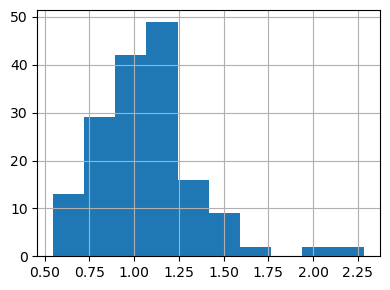

In [103]:
print(f"Year coverage: {conv_rate_year['launch_announced'].sort_values().unique()}")
conversion_rate.hist(figsize=(4, 3))
plt.tight_layout()

In [104]:
df_concat = pd.concat([conversion_rate, prices_ext.loc[conversion_rate.index]], axis=1)
util_data.compute_outlier(df_concat, "conversion_rate").sort_values(by="conversion_rate")

Lower bound: 0.55
Upper bound: 1.56
Number of outliers: 8


,conversion_rate,eur,usd
169,1.589414,526.08,330.99
1052,1.589414,526.08,330.99
1385,1.717929,749.00,435.99
502,1.717929,749.00,435.99
184,1.972696,578.00,293.00
1067,1.972696,578.00,293.00
1567,2.211872,1172.27,529.99
1493,2.286599,997.14,436.08


In [159]:
# split in train and test
# train, test = util_data.split_train_test(prices_ext, test_size=0.2, rng=rng)
X_train, y_train = train[curr.lower()].values.reshape(-1, 1), train["eur"].values
X_test, y_test = test[curr.lower()].values.reshape(-1, 1), test["eur"].values

params = {
    "epsilon": np.linspace(1, 2, num=10),
    "max_iter": [100],
    "alpha": np.linspace(0.0001, 0.1, num=20),
    "fit_intercept": [False],
    "tol": np.linspace(1e-5, 1e-4, num=10)
}
scoring = ["neg_mean_absolute_error", "r2"]
rscv = RandomizedSearchCV(HuberRegressor(), params, n_iter=100, scoring=scoring, n_jobs=-1,
                          refit="r2", cv=5, verbose=2, error_score=np.nan)
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=HuberRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([0.0001    , 0.00535789, 0.01061579, 0.01587368, 0.02113158,
       0.02638947, 0.03164737, 0.03690526, 0.04216316, 0.04742105,
       0.05267895, 0.05793684, 0.06319474, 0.06845263, 0.07371053,
       0.07896842, 0.08422632, 0.08948421, 0.09474211, 0.1       ]),
                                        'epsilon': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                                        'fit_intercept': [False],
                                        'max_iter': [100],
                                        'tol': array([1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05,
       9.e-05, 1.e-04])},
                   refit='r2', scoring=['neg_mean_absolute_error', 'r2'],
                   verbose=2)

In [166]:
usd_results = pd.DataFrame(rscv.cv_results_).sort_values("rank_test_neg_mean_absolute_error")
usd_sorted_r2= usd_results.sort_values(by="std_test_r2")
usd_sorted_rmse = usd_results.sort_values(by="std_test_neg_mean_absolute_error")
cols = ["std_test_r2", "mean_test_r2", "mean_test_neg_mean_absolute_error", "std_test_neg_mean_absolute_error"]
usd_results.iloc[:5][cols]

,std_test_r2,mean_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
87,0.194146,0.681986,-86.483241,25.509428
15,0.194146,0.681986,-86.483253,25.509419
53,0.194146,0.681986,-86.483253,25.509419
16,0.194146,0.681986,-86.483276,25.509399
58,0.194146,0.681986,-86.483276,25.509399


In [161]:
def print_best_n_search(df: pd.DataFrame, n: int, metrics: dict):
    for i in range(n):
        print(f"BEST {i+1} SEARCH:")
        for name, metric in metrics.items():
            print(f"STD {name}: {df.iloc[i][f'std_test_{metric}']}")
            print(f"MEAN {name}: {df.iloc[i][f'mean_test_{metric}']}")
            print(f"Rank {name}: {df.iloc[i][f'rank_test_{metric}']}", end="\n\n")
        print("---")

In [167]:
metrics = {"R2": "r2", "MAE": "neg_mean_absolute_error"}
print(f"---BEST R2---")
print_best_n_search(usd_sorted_r2, 3, metrics)
print(f"---BEST MAE---")
print_best_n_search(usd_sorted_rmse, 3, metrics)

---BEST R2---
BEST 1 SEARCH:
STD R2: 0.1778767023446916
MEAN R2: 0.6924911185895026
Rank R2: 1

STD MAE: 25.571544872898752
MEAN MAE: -87.05065615293589
Rank MAE: 100

---
BEST 2 SEARCH:
STD R2: 0.17787671308010156
MEAN R2: 0.6924911146526791
Rank R2: 2

STD MAE: 25.57154503719598
MEAN MAE: -87.05065477317567
Rank MAE: 99

---
BEST 3 SEARCH:
STD R2: 0.1778767362508994
MEAN R2: 0.692491097064998
Rank R2: 3

STD MAE: 25.571545056966254
MEAN MAE: -87.05065381259355
Rank MAE: 98

---
---BEST RMSE---
BEST 1 SEARCH:
STD R2: 0.17908882646446458
MEAN R2: 0.6883626019911133
Rank R2: 87

STD MAE: 24.99210275598061
MEAN MAE: -86.69142956165892
Rank MAE: 71

---
BEST 2 SEARCH:
STD R2: 0.1790887444312414
MEAN R2: 0.6883629400261851
Rank R2: 85

STD MAE: 24.992151307179476
MEAN MAE: -86.6913682323731
Rank MAE: 70

---
BEST 3 SEARCH:
STD R2: 0.1790886046921912
MEAN R2: 0.6883632294935613
Rank R2: 82

STD MAE: 24.992172539469667
MEAN MAE: -86.69133516300691
Rank MAE: 69

---


Results

The results shows that the conversion rate of the Huber regressor is approximately *1.058*, similar to the conversion rate retrieved from the European Central Bank, thus we decided to use the latter.

In [177]:
rate_train = train["eur"] / train[curr.lower()]

model_median = util_models.FixedLinearRegressor(
    rate_train.median(), fit_intercept=False
)
model_fit = HuberRegressor(**usd_results.iloc[0]["params"])
model_rate = util_models.FixedLinearRegressor(0.8694*1.22, fit_intercept=False)

models = [model_median, model_fit, model_rate]
names = ["median", "linear regressor", "online_rate"]

In [179]:
y_preds = util_models.compare_models(X_train, y_train, X_test, y_test, models, names)

median coefficients: [1.07572383]
median RMSE: 97.70
median r2-score: 0.85
median MAE: 58.81

linear regressor coefficients: [1.05882697]
linear regressor RMSE: 95.16
linear regressor r2-score: 0.86
linear regressor MAE: 57.22

online_rate coefficients: [1.060668]
online_rate RMSE: 95.42
online_rate r2-score: 0.86
online_rate MAE: 57.40



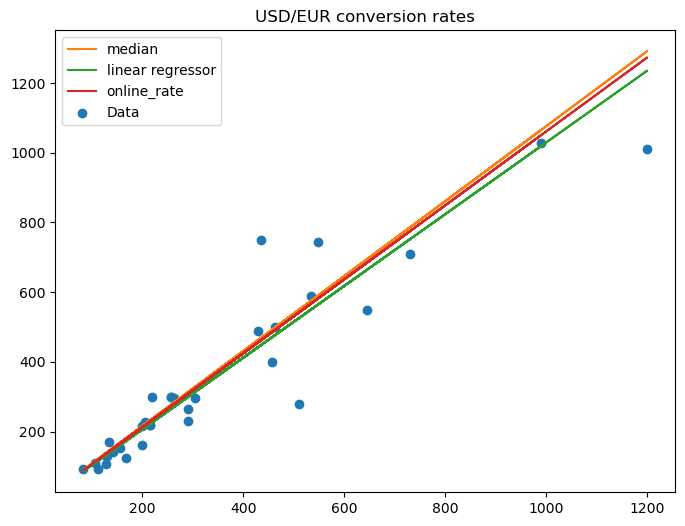

In [176]:
# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"{curr}/EUR conversion rates"
)

Conversion rate between GBP and EUR

The conversion rate retrieved from the ECB *1.1315*, while the median conversion rate is *1.0792*.

To estimate the conversion rate between GBP and EUR we still perform regression with the Huber regressor model (outliers are still present).

In [193]:
curr = "GBP"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price, first_eur=False)

# add the year to the conversion rate
conv_rate_year = pd.concat([conversion_rate, ser_year.loc[conversion_rate.index]], axis=1)

Number of prices: 187


Year coverage: [2018. 2019. 2020.]


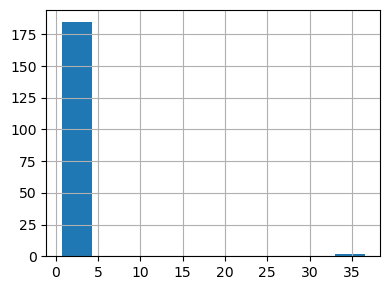

In [199]:
print(f"Year coverage: {conv_rate_year['launch_announced'].sort_values().unique()}")
conversion_rate.hist(figsize=(4, 3))
plt.tight_layout()

In [200]:
df_concat = pd.concat([conversion_rate, prices_ext.loc[conversion_rate.index]], axis=1)
util_data.compute_outlier(df_concat, "conversion_rate").sort_values(by="conversion_rate")

Lower bound: 0.76
Upper bound: 1.39
Number of outliers: 16


,conversion_rate,gbp,eur
184,0.680000,850.00,578.00
1067,0.680000,850.00,578.00
1500,0.759422,283.11,215.00
962,1.408325,528.99,744.99
79,1.408325,528.99,744.99
1502,1.408451,119.99,169.00
847,1.428587,279.99,399.99
820,1.438857,555.99,799.99
511,1.453978,204.90,297.92
1394,1.453978,204.90,297.92


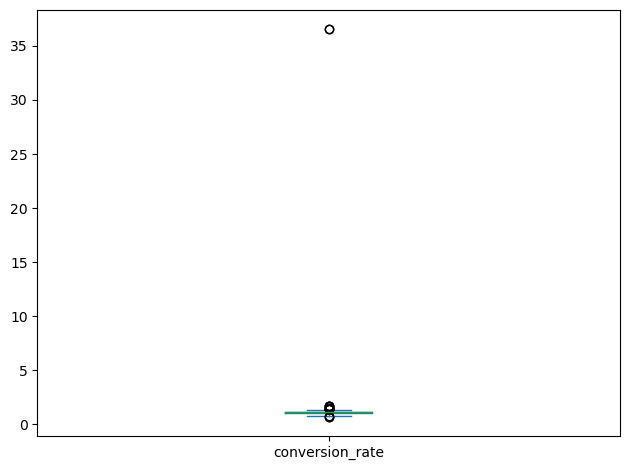

In [201]:
conversion_rate.plot.box(whis=1.5)
plt.tight_layout()

In [222]:
# split in train and test
train, test = util_data.split_train_test(prices_ext, test_size=0.2, rng=rng)
X_train, y_train = train[curr.lower()].values.reshape(-1, 1), train["eur"].values
X_test, y_test = test[curr.lower()].values.reshape(-1, 1), test["eur"].values

params = {
    "epsilon": np.linspace(1, 2, num=10),
    "max_iter": [100],
    "alpha": np.linspace(0.0001, 0.1, num=20),
    "fit_intercept": [False],
    "tol": np.linspace(1e-5, 1e-4, num=10)
}
scoring = ["neg_mean_absolute_error", "r2"]
rscv = RandomizedSearchCV(HuberRegressor(), params, n_iter=100, scoring=scoring, n_jobs=-1,
                          refit="r2", cv=5, verbose=2, error_score=np.nan)
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=HuberRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([0.0001    , 0.00535789, 0.01061579, 0.01587368, 0.02113158,
       0.02638947, 0.03164737, 0.03690526, 0.04216316, 0.04742105,
       0.05267895, 0.05793684, 0.06319474, 0.06845263, 0.07371053,
       0.07896842, 0.08422632, 0.08948421, 0.09474211, 0.1       ]),
                                        'epsilon': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                                        'fit_intercept': [False],
                                        'max_iter': [100],
                                        'tol': array([1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05,
       9.e-05, 1.e-04])},
                   refit='r2', scoring=['neg_mean_absolute_error', 'r2'],
                   verbose=2)

In [211]:
gbp_results = pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_neg_mean_absolute_error")
gbp_sorted_r2= gbp_results.sort_values(by="std_test_r2")
gbp_sorted_rmse = gbp_results.sort_values(by="std_test_neg_mean_absolute_error")
gbp_results.iloc[:5][cols]

,std_test_r2,mean_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
22,0.440197,0.718153,-58.003204,20.585625
7,0.440197,0.718153,-58.003205,20.585623
15,0.440197,0.718153,-58.003205,20.585623
74,0.440197,0.718153,-58.003210,20.585624
87,0.440197,0.718153,-58.003211,20.585605


In [225]:
print(f"---BEST R2---")
print_best_n_search(gbp_sorted_r2, 3, metrics)
print(f"---BEST MAE---")
print_best_n_search(gbp_sorted_rmse, 3, metrics)

---BEST R2---
BEST 1 SEARCH:
STD R2: 0.439241409264153
MEAN R2: 0.7178813901401159
Rank R2: 61

STD MAE: 20.326537064320508
MEAN MAE: -58.369182725078545
Rank MAE: 74

---
BEST 2 SEARCH:
STD R2: 0.43924141284589513
MEAN R2: 0.7178813650013284
Rank R2: 62

STD MAE: 20.32654584400644
MEAN MAE: -58.36918777903164
Rank MAE: 75

---
BEST 3 SEARCH:
STD R2: 0.43924141437120595
MEAN R2: 0.7178813542350674
Rank R2: 63

STD MAE: 20.326549608846896
MEAN MAE: -58.369189944910886
Rank MAE: 76

---
---BEST MAE---
BEST 1 SEARCH:
STD R2: 0.4398075685382518
MEAN R2: 0.7182998386397993
Rank R2: 27

STD MAE: 20.09657490084541
MEAN MAE: -58.15045998673715
Rank MAE: 47

---
BEST 2 SEARCH:
STD R2: 0.4398075685382518
MEAN R2: 0.7182998386397993
Rank R2: 27

STD MAE: 20.09657490084541
MEAN MAE: -58.15045998673715
Rank MAE: 47

---
BEST 3 SEARCH:
STD R2: 0.4398075698624437
MEAN R2: 0.7182998373527785
Rank R2: 29

STD MAE: 20.09657585705557
MEAN MAE: -58.15046002677116
Rank MAE: 49

---


Results

The results shows that the conversion rate of the Huber regressor is *1.0458*, which is the similar as the median conversion rate, however we chose the former.

In [226]:
rate_train = train["eur"] / train[curr.lower()]

model_median = util_models.FixedLinearRegressor(
    rate_train.median(), fit_intercept=False
)
model_fit = HuberRegressor(**gbp_results.iloc[0]["params"])
model_rate = util_models.FixedLinearRegressor(1.1315, fit_intercept=False)

models = [model_median, model_fit, model_rate]
names = ["median", "linear regressor", "online_rate"]

In [227]:
y_preds = util_models.compare_models(X_train, y_train, X_test, y_test, models, names)

median coefficients: [1.07927112]
median RMSE: 254.09
median r2-score: 0.40
median MAE: 78.58

linear regressor coefficients: [1.04589785]
linear regressor RMSE: 254.94
linear regressor r2-score: 0.40
linear regressor MAE: 78.40

online_rate coefficients: [1.1315]
online_rate RMSE: 254.48
online_rate r2-score: 0.40
online_rate MAE: 82.58



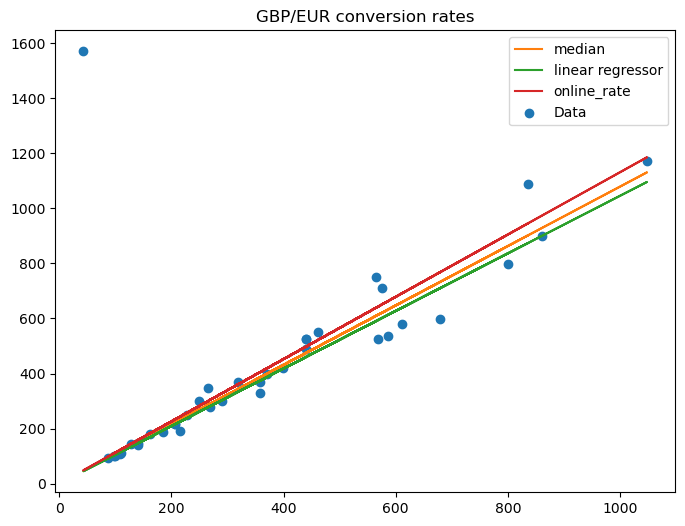

In [228]:
# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"{curr}/EUR conversion rates"
)

Conversion rate between INR and EUR

The conversion rate retrieved from the ECB *0.01268*, while the median conversion rate is *0.0114*.

To estimate the conversion rate between INR and EUR we perform linear regression (outliers aren't present).

In [233]:
curr = "INR"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat([conversion_rate, ser_year.loc[conversion_rate.index]], axis=1)

Number of prices: 40


Year coverage: [2019. 2020.]


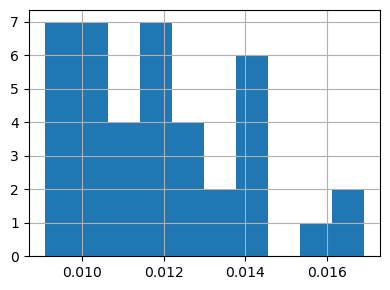

In [234]:
print(f"Year coverage: {conv_rate_year['launch_announced'].sort_values().unique()}")
conversion_rate.hist(figsize=(4, 3))
plt.tight_layout()

In [235]:
df_concat = pd.concat([conversion_rate, prices_ext.loc[conversion_rate.index]], axis=1)
util_data.compute_outlier(df_concat, "conversion_rate").sort_values(by="conversion_rate")

Lower bound: 0.01
Upper bound: 0.02
Number of outliers: 0


,conversion_rate,eur,inr


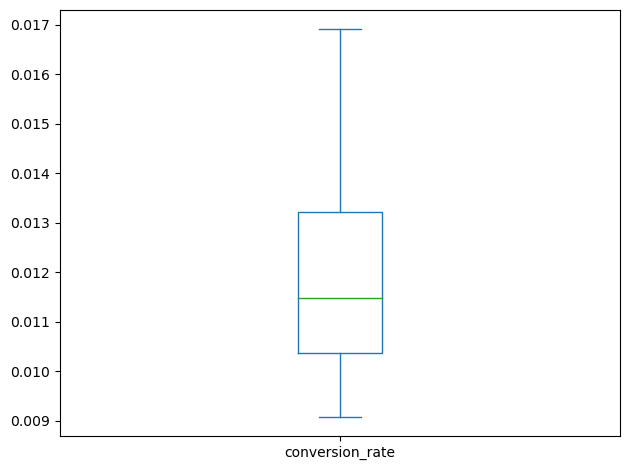

In [236]:
conversion_rate.plot.box(whis=1.5)
plt.tight_layout()

Results

The results shows that the conversion rate of the linear regression is the worst (probably due to few samples available), thus we opt for the median rate which gave the best results in the chosen metrics.

In [249]:
train, test = util_data.split_train_test(prices_ext, test_size=0.2, rng=rng)
X_train, y_train = train[curr.lower()].values.reshape(-1, 1), train["eur"].values
X_test, y_test = test[curr.lower()].values.reshape(-1, 1), test["eur"].values

rate_train = train["eur"] / train[curr.lower()]

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_linear = LinearRegression(fit_intercept=False)
model_rate = util_models.FixedLinearRegressor(0.01268, fit_intercept=False)

models = [model_median, model_fit, model_rate]
names = ["median", "linear regressor", "online_rate"]

In [250]:
y_preds = util_models.compare_models(X_train, y_train, X_test, y_test, models, names)

median coefficients: [0.01148827]
median RMSE: 34.01
median r2-score: 0.71
median MAE: 28.51

linear regressor coefficients: [0.01086622]
linear regressor RMSE: 38.09
linear regressor r2-score: 0.64
linear regressor MAE: 31.54

online_rate coefficients: [0.01268]
online_rate RMSE: 35.03
online_rate r2-score: 0.70
online_rate MAE: 31.87



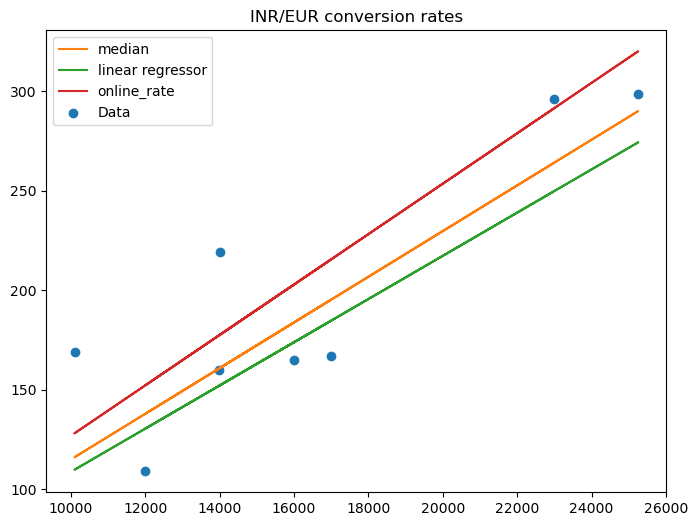

In [252]:
# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"{curr}/EUR conversion rates"
)

#### Continuous features

The disply size measure the diagonal of the screen in inches, while the battery capacity is measured in mAh.

In [294]:
df_copy[["display_size", "battery"]].head()

,display_size,battery
0,NaN,Removable Li-Ion battery
1,"3.5 inches, 34.9 cm",Removable Li-Ion 1500 mAh battery
2,"3.2 inches, 30.5 cm (~46.3% screen-to-body ratio)",Removable Li-Po 1230 mAh battery
3,"2.8 inches, 24.3 cm (~43.7% screen-to-body ratio)",Removable Li-Ion 1500 mAh battery
4,"6.3 inches, 98.0 cm (~81.3% screen-to-body ratio)",Non-removable Li-Po 3700 mAh battery


#### Binary features

These are *display_type*, *memory_card_slot*, *sound_loudspeaker*, *sound_3.5mm_jack*, *comms_wlan*, *comms_nfc*, *battery_charging* and *body*. 

These features are currently strings, but a more interesting representation is a binary one, so we can extract more relevant information from them.

- display_type: the display has the OLED technology
- comms_wlan: the technology of the wlan chipset, i.e. 2.4GHz or 5Ghz
- battery_charging: extract whether the device has support for fast-charging
- body: extract whether the device is waterproof
- memory_card_slot: the device contains a slot for a microSD
- sound_loudspeaker: the speaker is stereo or mono
- sound_3.5mm_jack: the device has a 3.5mm jack
- comms_nfc: the device supports the nfc

Display type

The *display_type* feature sometimes contains the keyword OLED, which depicts different display device technology, such as P-OLED, AMOLED or Super Retina. Otherwise the feature corresponds to a more general and worse technology, such as LCD or TFT.


In [295]:
df_copy[["display_type"]].head()

,display_type
0,Monochrome graphic
1,"TFT resistive touchscreen, 65K colors"
2,"TFT capacitive touchscreen, 256K colors"
3,"TFT capacitive touchscreen, 256K colors"
4,"P-OLED capacitive touchscreen, 16M colors"


Wireless connectivity

The *comms_wlan* feature contains the different [IEEE 802.11 standard](https://en.wikipedia.org/wiki/IEEE_802.11) supported. To distinguish whether the device supports the 5GHz or only the 2.4GHz depends on the standard adopted: the former is supported if at least one of "a" or "ac" generations is present in the feature.

In [291]:
df_copy[["comms_wlan"]].head()

,comms_wlan
0,No
1,Wi-Fi 802.11b/g
2,Wi-Fi 802.11 b/g
3,Wi-Fi 802.11 b/g
4,"Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Dire..."


Wireless charging

When the *battery_charging* feature contains the keyword wireless the device supports any type of wireless charging (QI), otherwise only a wired charging is possible.


In [296]:
df_copy[["battery_charging"]].head()

,battery_charging
0,NaN
1,NaN
2,NaN
3,NaN
4,Fast charging 18W USB Power Delivery 2.0 QI ...


Water resistence

The *body* feature might contain the keywords "IP6x", "splash" or "water" when the device is waterproof, a characteristic important for expensive devices.


In [297]:
df_copy[["body"]].head()

,body
0,NaN
1,NaN
2,NaN
3,Trackball
4,IP68 dust/water resistant (up to 1.5m for 30 m...


Miscellaneous

The remaining binary features usually contains the word "Yes" to describe the presence of the feature or in some case they explictly mention the feature.


In [298]:
df_copy[["memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_nfc"]].head()


,memory_card_slot,sound_loudspeaker,sound_3.5mm_jack,comms_nfc
0,No,No,No,NaN
1,microSDHC (dedicated slot),Yes,Yes,NaN
2,microSDHC (dedicated slot),Yes,Yes,NaN
3,microSDHC (dedicated slot),Yes,Yes,NaN
4,No,"Yes, with stereo speakers",No,Yes


#### Multi column features

The *display_resolution* feature contains the resolution of the display in pixels, both for the width and the height. If at least one of the two values is smaller than 1000, then the value is dropped because it's too small to be a smartphone display (smartwatch or an old smartphone).

For the *memory_internal*, it represents the internal memory of the device in GB, both for the RAM and the ROM. When the device has at least one capacity expressed in MB, then the value is dropped because it's too small to be relevant.


In [300]:
df_copy[["display_resolution", "memory_internal"]].head()

,display_resolution,memory_internal
0,6 lines,NaN
1,"480 x 800 pixels, 5:3 ratio (~267 ppi density)",4GB 512MB RAM
2,"320 x 480 pixels, 3:2 ratio (~180 ppi density)",256MB RAM
3,"240 x 320 pixels, 4:3 ratio (~143 ppi density)","256MB RAM, 512MB"
4,"1440 x 3040 pixels, 19:9 ratio (~537 ppi density)","64GB 6GB RAM, 128GB 6GB RAM"


#### Network technology

The *network_technology* feature contains the different network technologies supported by the device. The most important ones are:

- 5G: the device supports the 5G network
- 4G: the device supports the 4G network, usually described as LTE.
- 3G: the device supports the 3G network, usually described as UMTS or HSPA.

The other technologies are less important, such as GSM, CDMA, EVDO or even devices with no network support are dropped.


In [301]:
df_copy[["network_technology"]].head()


,network_technology
0,GSM
1,GSM / HSPA
2,GSM / HSPA
3,GSM / HSPA
4,GSM / CDMA / HSPA / EVDO / LTE


#### Camera features

Each feature is split into different columns, each one describing a different setup of the camera(s) in the device. The columns are named as *main_camera_single*, *main_camera_dual*, etc. The number of columns is variable, depending on the number of cameras present in the device.

Only one column for both "main" and "selfie" camera is filled (e.g. *main_camera_single* and *selfie_camera_dual* are filled), while the other columns are filled with NaN values. In this way the resolution of only the principal camera is considered, while the other ones are ignored. In addition, the number of cameras is extracted both for the main and the selfie cameras.

Main camera

In [302]:
main_cols = ["main_camera_single", "main_camera_dual", "main_camera_quad", "main_camera_triple", "main_camera_five", "main_camera_dual_or_triple"]
df_copy[main_cols].head()

,main_camera_single,main_camera_dual,main_camera_quad,main_camera_triple,main_camera_five,main_camera_dual_or_triple
0,NaN,NaN,NaN,NaN,NaN,NaN
1,"5 MP, AF",NaN,NaN,NaN,NaN,NaN
2,"5 MP, AF",NaN,NaN,NaN,NaN,NaN
3,"2 MP, AF",NaN,NaN,NaN,NaN,NaN
4,NaN,"12.2 MP, f/1.7, 27mm (wide), 1/2.55"", 1.4<c2><...",NaN,NaN,NaN,NaN


Selfie camera

In [303]:
selfie_cols = ["selfie_camera_single", "selfie_camera_dual", "selfie_camera_triple"]
df_copy[selfie_cols].head()

,selfie_camera_single,selfie_camera_dual,selfie_camera_triple
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,"8 MP, f/2.0, 22mm (wide), 1.22<c2><b5>m, no AF...",NaN


## Preprocessing


We preprocess the data in order to make it suitable for the task. The preprocessing steps are the following:

- Drop the columns which are not relevant for the task.
- Process each feature in order to make it suitable for the task, as described in the previous section.
- For some features, such as binary features, the NaN values are replaced to depict the absence of the feature. The samples where the NaN values in the features cannot be estimated are dropped.

Many samples are dropped, but mostly because they are old devices, which are not relevant for the task, for example if the display resolution is smaller than 1000 pixels or if the internal memory is smaller than 1GB.

The final dataset contains 2159 samples and 22 features.

In [9]:
filter_condition = [
    ("launch_announced", lambda x: x >= 2014),
    ("display_size", lambda x: (x >= 4) & (x <= 7.5)),
    ("display_height", lambda x: x >= 512),
    ("display_width", lambda x: x >= 512),
    ("num_main_camera", lambda x: x <= 4),
    ("memory_rom_gb", lambda x: x <= 256),
    ("memory_ram_gb", lambda x: x <= 32),
    ("battery", lambda x: x>= 1000),
    ("misc_price", lambda x: x <= 2000),
]

Filtering

The dataset is filtered to keep only the samples which satisfy the following conditions:

- *launch_announced* greater or equal than 2014;
- *display_size* between 4 inches and 7.5 inches;
- *display_height* and *display_width* greater or equal than 512 pixels;
- *num_main_camera* lower or equal than 4;
- *battery* greater or equal than 1000 mAh
- *misc_price* lower than 2000€.

With these conditions the dataset is reduced but we can be sure that the samples are smartphones and the most recent.

In [13]:
preprocess = util_preprocess.GSMArenaPreprocess("gsmarena.json")
df = preprocess(df_raw, filter_condition, verbose=False)

print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe has 2159 rows and 22 columns.


Final dataset

Instead of simply removing duplicates, we keep only one duplicated sample by considering the median price. This is done because the price is the target of the task and we want to avoid that the model is biased towards the most expensive device.

Other techniques for detecting duplicates are possible, such as clustering or PCA, but the median price is a simple and effective way to remove duplicates.

We end up with 1911 samples which can be used for the classification task.

In [14]:
# Show duplicated rows
def get_dup_rows(df: pd.DataFrame, drop_cols):
    dup_cols = df.columns.drop(drop_cols).to_list()
    dup_rows = df[df.duplicated(subset=dup_cols, keep=False)].copy()
    return dup_rows, dup_rows.groupby(dup_cols)


df_duplicates, df_groups = get_dup_rows(df, ["misc_price", "launch_announced", "oem_model"])

print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Number of duplicated rows: {df_groups.ngroups}")

# remove dupliates rows which are then substitued
df = df.drop(df_duplicates.index).reset_index(drop=True)
print(f"The dataframe after removing duplicates has {df.shape[0]} rows")

# add duplicated rows by joining the rows and replacing with the median price
for key, item in df_groups:
    el = item.iloc[0, :].copy()
    el.misc_price = item.misc_price.median()
    el.launch_announced = item.launch_announced.max()

    # define the oem and model
    oem_model = item.oem_model.unique()
    if len(oem_model) > 1:
        oem_model = " - ".join(oem_model)
    else:
        oem = oem[0]

    el.oem_model = oem_model
    
    df = pd.concat([df, el.to_frame().T], axis=0)

df = df.reset_index(drop=True)
print(f"The dataframe after adding duplicates has {df.shape[0]} rows")


The dataframe has 2159 rows and 22 columns.
Number of duplicated rows: 182
The dataframe after removing duplicates has 1729 rows
The dataframe after adding duplicates has 1911 rows


In [15]:
# save the dataframe
df.to_csv("data/processed/gsm.csv", index=True)